## Individual household electric power consumption Data Set

***

#### Primarily trying to device the method that could be used to forecast energy consumption of the upcoming month, based on one months data only. A lot of experimentations done over different models. The experimentation is demonstrated and results are plotted as well.

#### **The 5 methods that are worked upon are:**

> ####   1 - ARIMA Forecasting for 1 timestep and for whole month
> ####   2 - Facebook Prophet forecasting based on variable amount of training data
> ####   3 - Using Auto Regression (AR) with walk-forward validation 
> ####   4 - Using Moving Average (MA) with anamoly detection within data
> ####   5 - Using Deep Learning for Time Series modeling

***

#### The accuracy over here does not depend on the individual daily predictions that are calculated against yhat and true value. The Goal here is to predict the overall energy consumption in the month. Therefore, the individual predictions may not seem as accurate as they should be, but the commulative monthly energy consumptions (sum of yhat) when compared against the actual monthly consumption (from the test set) could potentially have better results

***


#### The accuracy of overall energy consumption is deduced through the following simple metric:

> #### **Percent Error = ( |Experimental Value – Theoretical Value| ÷ Theoretical Value) x 100**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
import seaborn as sns                            # more plots
sns.set()

warnings.filterwarnings("ignore")

# Preprocessing

In [6]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
dfSeven = df.loc["2007":"2007"] #Selecting only 1 year data
dfSeven = dfSeven.resample('D').sum() # Resampling it over days
dfSeven.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2007-01-01,2749.004,148.166,345785.73,11400.4,0.0,352.0,5880.0
2007-01-02,1269.236,190.342,348399.04,5348.2,0.0,348.0,6562.0
2007-01-03,1014.054,196.728,350722.21,4340.2,0.0,344.0,4765.0
2007-01-04,3259.412,202.302,345240.43,13648.6,1051.0,7597.0,10896.0
2007-01-05,2713.364,173.154,346313.90,11354.6,1483.0,379.0,7602.0


Text(0.5, 1.0, 'Overall Energy Trend of Data')

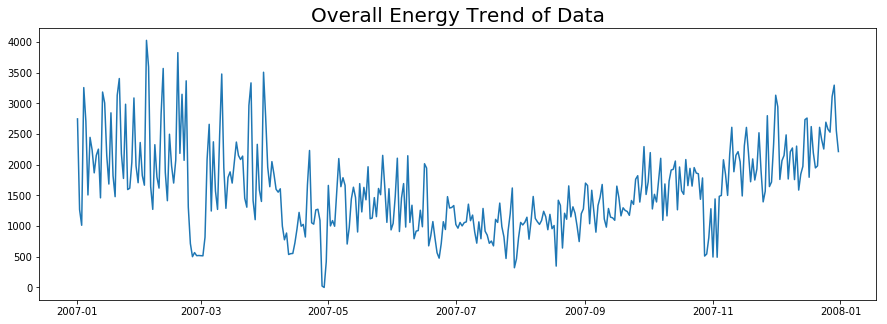

In [7]:
plt.figure(figsize=(15,5))
plt.plot(dfSeven.index, dfSeven.Global_active_power)
plt.title("Overall Energy Trend of Data", fontdict= {'fontSize': 20})

Text(0.5, 1.0, 'Monthly Plot')

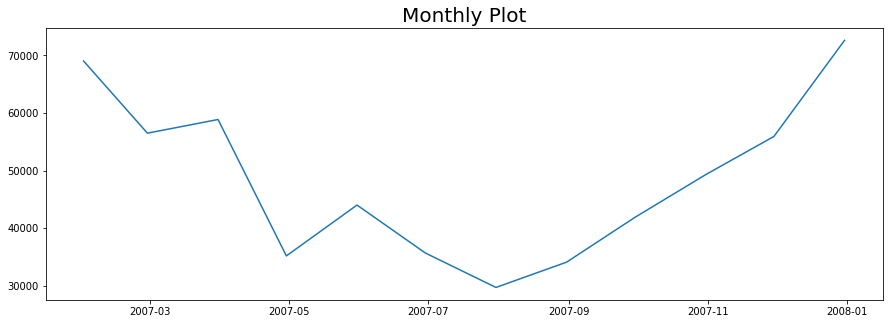

In [8]:
# arima.resample('M').sum().index
plt.figure(figsize=(15,5))
plt.plot(dfSeven.resample('M').sum().index, dfSeven.resample('M').sum().Global_active_power)
plt.title("Monthly Plot", fontdict= {'fontSize': 20})

# ARIMA Model
#### Arguments
    - arima -- DataFrame(dt, Global_active_power)
    - order -- (2,2,0) | arima (p,d,q)
    - split_ration -- dataset split ration | 0.51

In [301]:
dfMonth = dfSeven.loc["2007-03":"2007-04"] #Selecting 2 months for train and testing
dfMonth = dfMonth.resample('D').sum()
arima = pd.DataFrame(dfMonth['Global_active_power']) # Selecting only the relevant feature for ARIMA dataframe
arima.head()

,Global_active_power
dt,
2007-03-01,517.564
2007-03-02,515.688
2007-03-03,819.122
2007-03-04,2090.700
2007-03-05,2660.332


In [302]:
dfMonth.shape

(61, 7)

In [303]:
def arimaForecast(arima, order, split_ratio = 0.7, yhatFlag=True):
    warnings.filterwarnings("ignore")
    X = arima.values
    size =round(len(arima) * split_ratio)
    train, test = X[0:size], X[size:]
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
    #     print(output)
        yhat = output[0]
        predictions.append(yhat)
        obs = yhat
        if yhatFlag:
            history.append(yhat)
        else:
            history.append(test[t])
#         print('predicted=%f, expected=%f' % (yhat, obs))
    
    error = mean_squared_error(test, predictions)
    
    return error, train, test, predictions, history

### Grid Search Arima Parameters

In [81]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse, _,_,_,_ = arimaForecast(dataset, order, split_ratio=0.51)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [82]:
# evaluate parameters
series = arima.values
p_values = [0,1,2,3,4,5,6,7]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [83]:
evaluate_models(arima, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=673571.104
ARIMA(0, 0, 1) MSE=295750.363
ARIMA(0, 0, 2) MSE=328467.390
ARIMA(0, 1, 0) MSE=222495.842
ARIMA(0, 1, 1) MSE=369607.386
ARIMA(0, 1, 2) MSE=258245.314
ARIMA(0, 2, 0) MSE=638100.507
ARIMA(0, 2, 1) MSE=227344.829
ARIMA(1, 0, 0) MSE=295288.135
ARIMA(1, 1, 0) MSE=225416.187
ARIMA(1, 1, 1) MSE=304931.172
ARIMA(1, 2, 0) MSE=546782.333
ARIMA(2, 0, 0) MSE=387632.864
ARIMA(2, 0, 1) MSE=384210.876
ARIMA(2, 0, 2) MSE=333287.919
ARIMA(2, 1, 0) MSE=207006.714
ARIMA(2, 1, 1) MSE=271556.732
ARIMA(2, 1, 2) MSE=295762.017
ARIMA(2, 2, 0) MSE=386909.118
ARIMA(2, 2, 1) MSE=192291.616
ARIMA(3, 0, 0) MSE=245164.512
ARIMA(3, 1, 0) MSE=216973.525
ARIMA(3, 1, 1) MSE=281742.136
ARIMA(3, 2, 0) MSE=320173.596
ARIMA(4, 0, 0) MSE=322471.420
ARIMA(4, 0, 1) MSE=352252.539
ARIMA(4, 1, 0) MSE=234819.966
ARIMA(4, 1, 1) MSE=363490.269
ARIMA(4, 2, 0) MSE=298695.251
ARIMA(5, 0, 0) MSE=321365.569
ARIMA(5, 0, 1) MSE=321388.138
ARIMA(5, 1, 0) MSE=326897.996
ARIMA(5, 1, 1) MSE=376913.225
ARIMA(5, 2

## Predictions with appending Yhat to History

### Percent Error = ( |Experimental Value – Theoretical Value| ÷ Theoretical Value) x 100

In [310]:
_,train, test, predictions, history = arimaForecast(arima, order=(2,2,1), split_ratio=0.51, yhatFlag=True)

Test MSE: 754689.146


Text(3, 8, ' TEST: 35181.0\n PREDICTION: 51707.0\n Error: [46.97153672]')

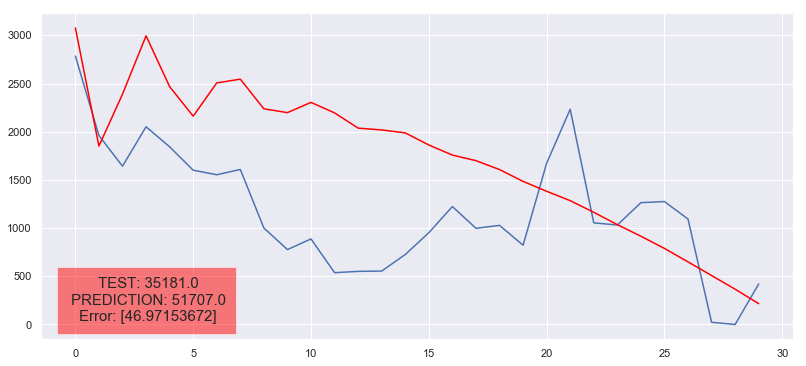

In [312]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize = (12,6))
plt.plot(test)
plt.plot(predictions, color='red')
perc = (abs(sum(predictions) - sum(test)) / (sum(test)))*100
plt.text(3, 8, " TEST: {}\n PREDICTION: {}\n Error: {}".format(round(sum(test)[0]), round(sum(predictions)[0]), perc), 
         fontsize=15, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}, verticalalignment='bottom', horizontalalignment='center')

# plt.savefig("Arima/close2.png")

### Predictions with appending Actual Value of Y to History

In [305]:
_,train, test, predictions, history = arimaForecast(arima, order=(2,2,1), split_ratio=0.51, yhatFlag=False)

Test MSE: 192288.737


Text(3, 8, ' TEST: 35181.0\n PREDICTION: 33753.0\n Error: [4.05886539]')

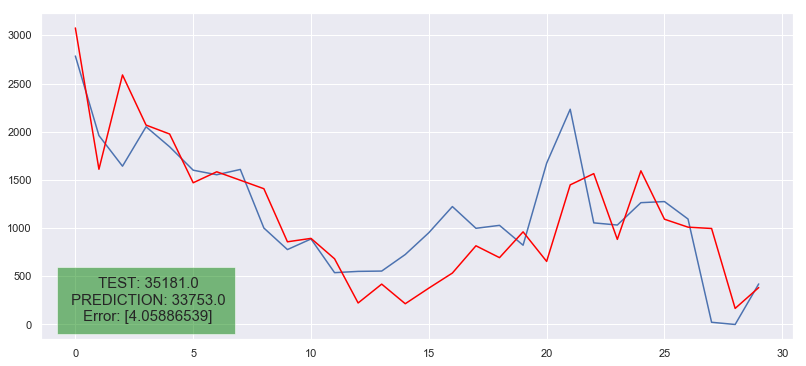

In [309]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize = (12,6))
plt.plot(test)
plt.plot(predictions, color='red')
perc = (abs(sum(predictions) - sum(test)) / (sum(test)))*100
plt.text(3, 8, " TEST: {}\n PREDICTION: {}\n Error: {}".format(round(sum(test)[0]), round(sum(predictions)[0]), perc), 
         fontsize=15, bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10}, verticalalignment='bottom', horizontalalignment='center')

# plt.savefig("Arima/close2.png")

# FB Prophet

In [218]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

%matplotlib inline

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [313]:
prophet = pd.DataFrame(dfSeven['Global_active_power'])
prophet.index = pd.to_datetime(prophet.index)

In [314]:
prophet.head()

,Global_active_power
dt,
2007-01-01,2749.004
2007-01-02,1269.236
2007-01-03,1014.054
2007-01-04,3259.412
2007-01-05,2713.364


In [315]:
train = prophet.copy().loc["2007-01":"2007-03"]
test = prophet.copy().loc["2007-04":"2007-04"]

train.reset_index(inplace=True)
test.reset_index(inplace=True)

train.columns = ['ds', 'y']
test.columns = ['ds', 'y']

print("Train Shape: {}, Test Shape: {}".format(train.shape, test.shape))

Train Shape: (90, 2), Test Shape: (30, 2)


## Prophet Model

In [231]:
model = Prophet(weekly_seasonality=False,
                yearly_seasonality=False, daily_seasonality=False).add_seasonality(name = 'weekly',
                                                                                   period = 7,
                                                                                  fourier_order=15).add_seasonality(name = 'daily',
                                                                                   period = 1,
                                                                                  fourier_order=20).add_seasonality(name = 'monthly',
                                                                                   period = 30.5,
                                                                                  fourier_order=15)
model.fit(train)

## Forecasting

In [232]:
testForecast = test.copy().drop('y', axis=1)
testForecast.head()

,ds
0,2007-04-01
1,2007-04-02
2,2007-04-03
3,2007-04-04
4,2007-04-05


In [233]:
forecast = model.predict(testForecast)
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
25,2007-04-26,881.464361,135.119767,1588.867826
26,2007-04-27,372.272748,-333.290630,1111.593965
27,2007-04-28,1740.802000,1102.395051,2480.347845
28,2007-04-29,1814.549209,1096.126167,2551.542773
29,2007-04-30,1658.986819,962.825745,2400.330276


### Plotting

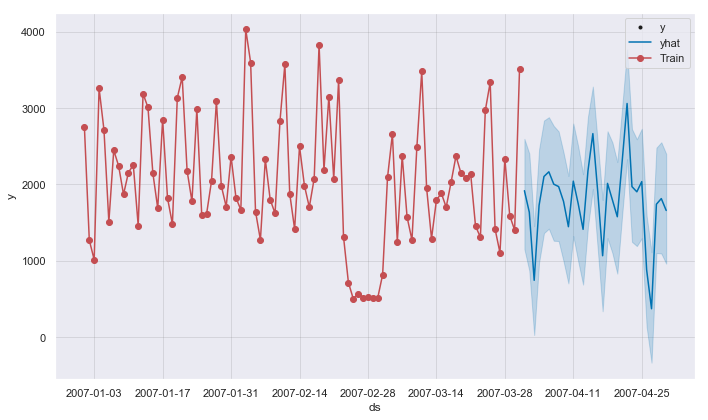

In [262]:
a = model.plot(forecast)
plt.plot(train.ds, train.y, marker='o', label="Train", color='r')
plt.legend()

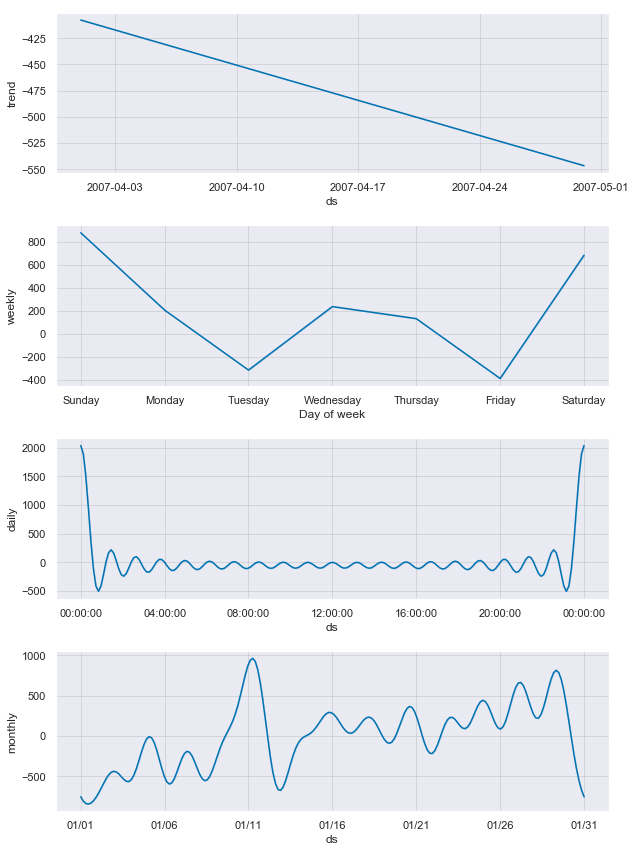

In [264]:
a = model.plot_components(forecast)

In [234]:
perc = (abs(sum(forecast['yhat']) -  sum(test['y'])) / sum(test['y'])) * 100
perc

52.45765442423321

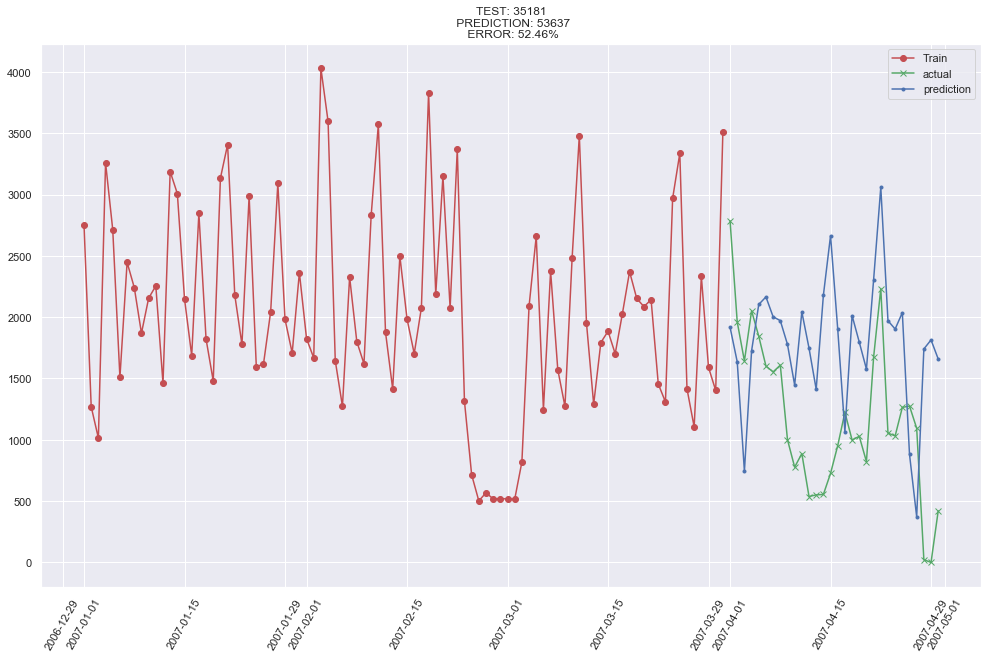

In [263]:
plt.figure(figsize = (15, 10))
# model.plot(forecast)
plt.plot(train.ds, train.y, marker='o', label="Train", color='r')
plt.plot(test.ds, test.y, marker='x', label="actual", color='g')
plt.plot(forecast.ds, forecast.yhat,marker = '.', color='b', label="prediction")
plt.xticks(rotation=60)
plt.title("TEST: {}\n PREDICTION: {}\n ERROR: {}%".format(round(sum(test['y'])), round(sum(forecast['yhat'])), round(perc, 2)))

plt.legend()

## Auto Regression (AR) and Moving Average (MA)

In [46]:
def arForecast(ar, split_ratio = 0.7):
    warnings.filterwarnings("ignore")
    X = ar.values
    size =round(len(ar) * split_ratio)
    train, test = X[0:size], X[size:]
    
    model = AR(train)
    modelFit = model.fit()
    window = modelFit.k_ar
    coef = modelFit.params
    
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))
     
    
    return test, predictions
    

In [47]:
dfMonth = dfSeven.loc["2007-03":"2007-04"] #Selecting 2 months for train and testing
dfMonth = dfMonth.resample('D').sum()
ar = pd.DataFrame(dfMonth['Global_active_power']) # Selecting only the relevant feature for ARIMA dataframe
ar.head()

,Global_active_power
dt,
2007-03-01,517.564
2007-03-02,515.688
2007-03-03,819.122
2007-03-04,2090.700
2007-03-05,2660.332


In [49]:
test, predictions = arForecast(ar, split_ratio=0.51)

Test MSE: 5515687.053


Text(3, 8, ' TEST: 35181.0\n PREDICTION: 91869.0\n Error: 161.0')

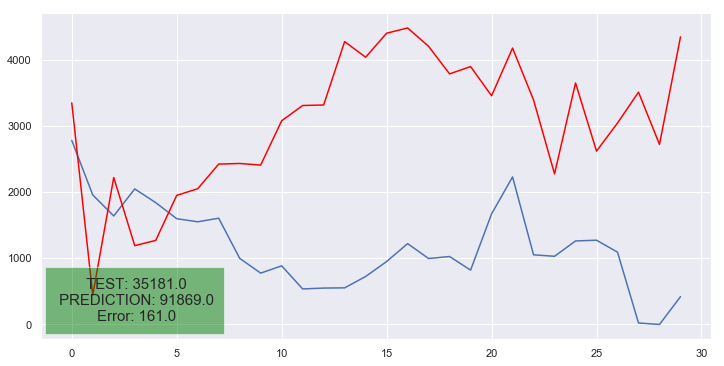

In [53]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize = (12,6))
plt.plot(test)
plt.plot(predictions, color='red')
perc = (abs(sum(predictions) - sum(test)) / (sum(test)))*100
plt.text(3, 8, " TEST: {}\n PREDICTION: {}\n Error: {}".format(round(sum(test)[0]), round(sum(predictions)[0]), round(perc[0])), 
         fontsize=15, bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10}, verticalalignment='bottom', horizontalalignment='center')

## Moving Average (MA)

In [257]:
movingAvg = (dfSeven['Global_active_power'])
movingAvg.head()

dt
2007-01-01    2749.004
2007-01-02    1269.236
2007-01-03    1014.054
2007-01-04    3259.412
2007-01-05    2713.364
Freq: D, Name: Global_active_power, dtype: float64

In [258]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    
    plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(series[window:], label="Actual values")
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        

    plt.legend(loc="upper left")
    plt.grid(True)

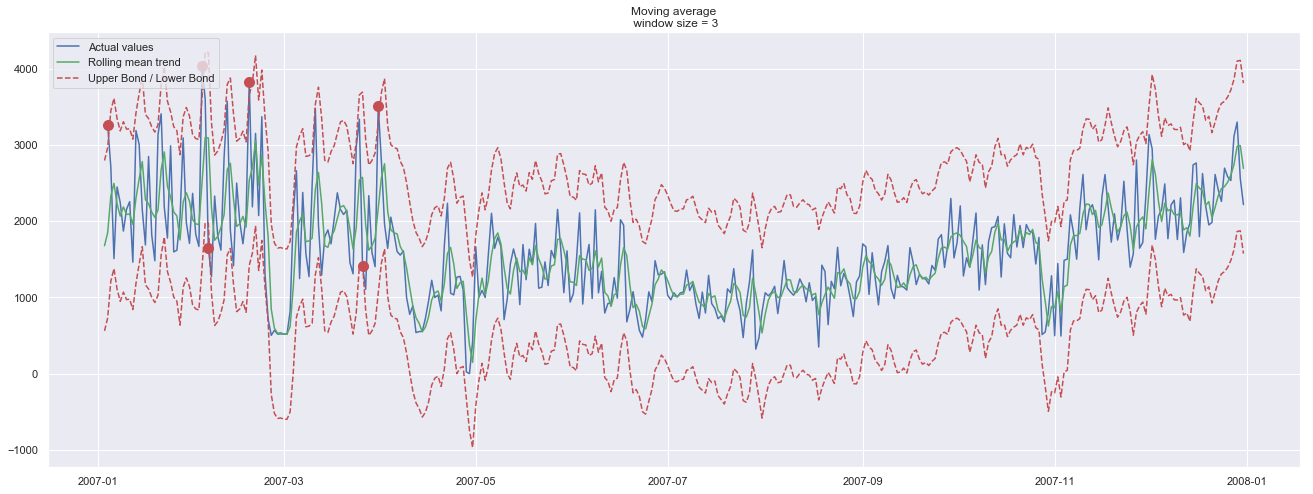

In [260]:
plotMovingAverage(pd.DataFrame(movingAvg), 3, plot_intervals=True, plot_anomalies=True)

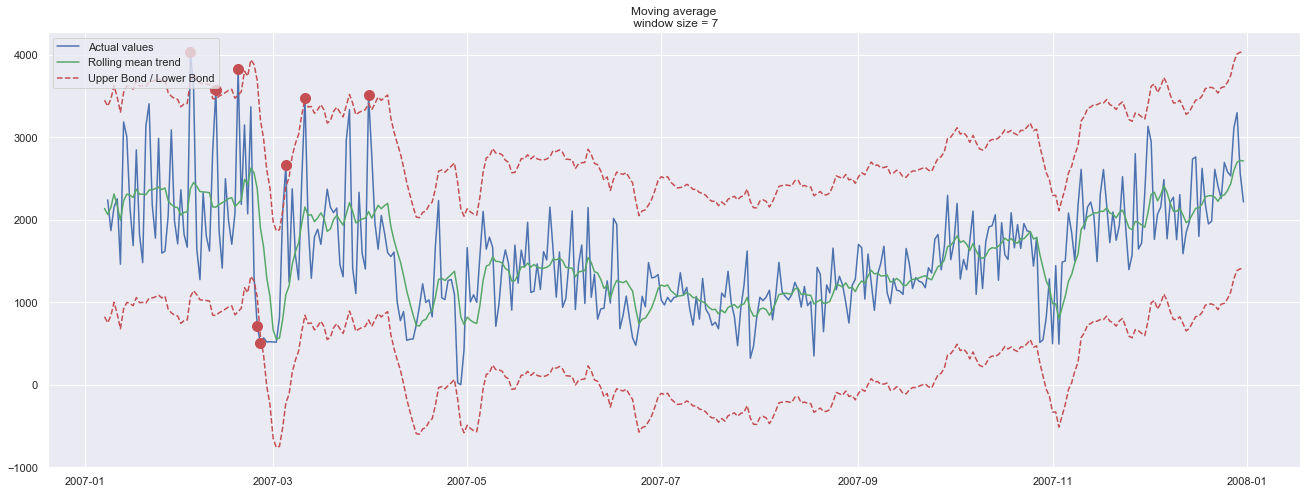

In [261]:
plotMovingAverage(pd.DataFrame(movingAvg), 7, plot_intervals=True, plot_anomalies=True)